<h1>Ingestão dos Dados do Telegram</h1>

<p><strong>Descrição:</strong> Todo material utilizado para o desenvolvimento desse notebook foi disponibilizado pela <a href="https://ebaconline.com.br/analista-de-dados">EBAC</a>.</p>
<p>Passo a passo:</p>
<ol>
<li>Criar um bucket no AWS S3 ;
<li>Criar uma função no AWS Lambda ;
<li>Criar uma API web no AWS API Gateway ;
<li>Configurar o webhook da API de bots do Telegram.
</ol>

<h2>1. Criação do bucket no AWS S3</h2>
<p>Na etapa de ingestão, o AWS S3 tem a função de passivamente armazenar as
mensagens captadas pelo bot do Telegram no seu formato original: JSON. Para tanto, basta a criação de um bucket.</p>

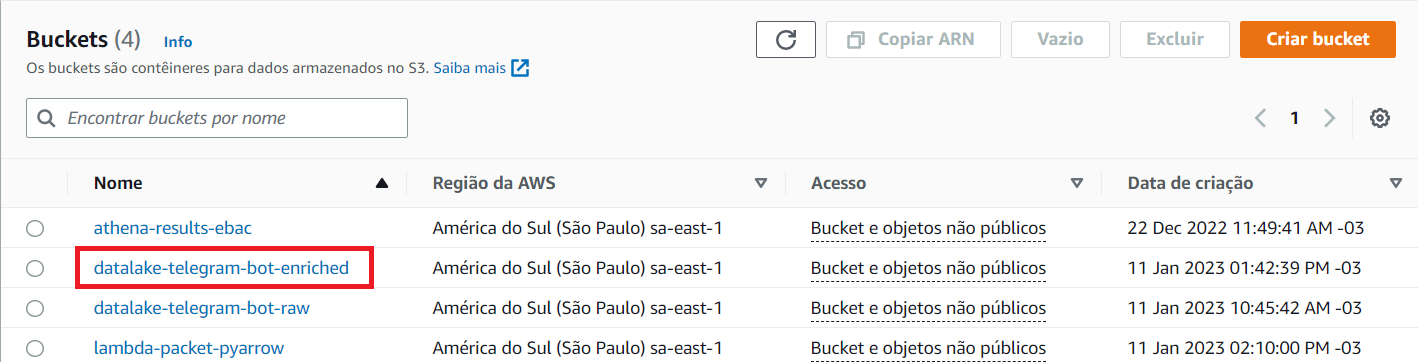

<h2>2. Criar uma função no AWS Lambda</h2>
<p>Para esse ponto será criado uma função que opera da seguinte forma:</p>
<ul>
<li>Recebe a mensagem no parâmetro event ;
<li>Verifica se a mensagem tem origem no grupo do Telegram correto;
<li>Persiste a mensagem no formato JSON no bucket do AWS S3 ;
<li>Retorna uma mensagem de sucesso (código de retorno HTTP igual a 200) a API de bots do Telegram.
</ul>
<p><strong>O código para colocar na função lambda:</stron></p>

In [ ]:
# Bibliotecas utilizadas:
import os
import json
import logging
from datetime import datetime, timezone, timedelta

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve, 
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente
  BUCKET = os.environ['AWS_S3_BUCKET']#informe o nome do bucket.
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])#informe o id de uma mensagem.

  # vars lógicas
  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal
  client = boto3.client('s3')
  
  try:
    # Salva a mensagem:
    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')
  # Se ocorrer algum erro no processo será apresentando o código HTTP 500:
  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")
  # Se tudo ocorrer como esperado apresentará a informação do código HTTP 200:
  else:
      return dict(statusCode="200")

<p><li><strong>OBS:</strong> Por fim, será preciso atribuir a permissão de escrita no bucket do <code>AWS S3</code> para a função do <code>AWS Lambda</code> no <code>AWS IAM</code>.</p>

<h2>3. Criar uma API web no AWS API Gateway</h2>
<p>Na etapa, o <code>AWS API Gateway</code> tem a função de receber as mensagens
captadas pelo bot do Telegram, enviadas via webhook, e iniciar uma função do <code>AWS
Lambda</code> , passando o conteúdo da mensagem no seu parâmetro event. Para isso, será preciso criar uma API e configurá-la como gatilho da função do <code>AWS Lambda</code> :</p>
<ul>
  <li>Acesse o serviço e selecione: Create API -> REST API;
  <li>Insira um nome, como padrão, um que termine com o sufixo <code>-api</code>;
  <li>Selecione: <em>Actions</em> -> <em>Create Method</em> -> <em>POST</em>;
  <li>Na tela de setup:
  <ul>
    <li>Selecione Integration type igual a Lambda Function;
    <li>Habilite o Use Lambda Proxy integration;
    <li>Busque pelo nome a função do <code>AWS Lambda</code>.
  </ul>
  <p>Por fim, vamos fazer a implantação da API e obter o seu endereço web.
  Selecione:</p>
  <ol>
    <li><em>Actions</em> -> <em>Deploy API</em>;
    <li>Selecione: <em>New Stage</em> para <em>Deployment stage</em>;
    <li>Adicione dev como <code>Stage name</code>.
  </ol>
  <li><mark>Copie o a <strong>url</strong> gerada na variável <strong>aws_api_gateway_url</strong>.</mark>
</ul>
<p>Código Python para reconhecer a url da API gateway:</p>


In [ ]:
import getpass
# O getpass vai ocultar as informações da URL da API gateway:
aws_api_gateway_url = getpass()

<h2>4. Configurar o webhook da API de bots do Telegram</h2>
<ul><li>O método setWebhook configura o redirecionamento das mensagens captadas pelo bot para o endereço web do paramametro url.</ul>





In [ ]:
# setWebhook:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')
print(json.dumps(json.loads(response.text), indent=2))

<p>Configurando o getWebhookInfo:</p>
<ul><li>O método getWebhookInfo retorna as informações sobre o webhook configurado</ul>

In [ ]:
# confirmando se o getWebhookInfo funcionou:
response = requests.get(url=f'{base_url}/getWebhookInfo')
print(json.dumps(json.loads(response.text), indent=2))